In [1]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

from dataset import sequence

import numpy as np
import matplotlib.pyplot as plt

from models.transformer import *

In [2]:
def train(model: nn.Module, optim: torch.optim, x: Tensor, t:Tensor, batch_size: int, max_epoch: int) -> list:
    loss_list = []
    
    model.train()
    for epoch in range(max_epoch):
        idx = np.random.permutation(np.arange(data_size))
        x = x[idx]
        t = t[idx]

        for iters in range(len(x) // batch_size):
            batch_x = x[(iters * batch_size) : (iters + 1) * batch_size]
            batch_t = t[(iters * batch_size) : (iters + 1) * batch_size]

            batch_x = torch.Tensor(batch_x).type(torch.long)
            batch_t = torch.Tensor(batch_t).type(torch.long)

            target = batch_t[:, 1:]
            batch_t = batch_t[:, :-1]

            mask = model.get_seq_mask(batch_t.shape[1])

            output = model.forward(batch_x, batch_t, mask)
            loss = criterion(output.view(-1, ntokens), target.reshape(-1))

            optim.zero_grad()
            loss.backward()
            optim.step()
            
            loss_list += [loss.item()]
            
            if iters % 20 == 0:
                print(f'{epoch}({iters}): {loss.item()}')
            
    return loss_list

In [3]:
def evaluate(model: nn.Module, optim: torch.optim, x: Tensor, t:Tensor, batch_size: int) -> list:
    loss_list = []
    
    model.eval()
    for iters in range(len(x) // batch_size):
        batch_x = x[(iters * batch_size) : (iters + 1) * batch_size]
        batch_t = t[(iters * batch_size) : (iters + 1) * batch_size]
        
        batch_x = torch.Tensor(batch_x).type(torch.long)
        batch_t = torch.Tensor(batch_t).type(torch.long)
        
        target = batch_t[:, 1:]
        batch_t = batch_t[:, :-1]
        
        mask = model.get_seq_mask(batch_t.shape[1])
        
        output = model.forward(batch_x, batch_t, mask)
        loss = criterion(output.view(-1, ntokens), target.reshape(-1))
        
        loss_list += [loss.item()]
        
        if iters % 20 == 0:
            print(f'{iters}: {loss.item()}')
            
    return loss_list

In [4]:
def generate(model: nn.Module, x: Tensor, t:Tensor, token_id: int, seq_len: int):
    b, n = x.shape
    x = torch.Tensor(x).type(torch.long)
    mask = model.get_seq_mask(seq_len)
    pred = model.generate(x, torch.Tensor([token_id]).repeat(b).unsqueeze(-1).type(torch.long), seq_len, mask)
    
    
    for b in range(b):
        query = ''.join(id_to_char[x] for x in x[b].numpy())
        target = ''.join(id_to_char[x] for x in t[b])
        a = ''.join(id_to_char[x] for x in pred[b].numpy())

        print(f'Q: {query}')
        print(f'T: {target}')
        print(f'{"O" if target == a else "X"}: {a}')
        print('--')

In [5]:
def loss_graph(loss_list: list, label: str):
    iters = np.arange(len(train_loss))
    plt.plot(iters, train_loss, label='train')
    plt.xlabel('iters')
    plt.ylabel(label)
    plt.show()

In [6]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

In [7]:
ntokens = len(char_to_id)
max_len = 100
d_model = 128
d_ff = d_model * 4
nheads = 2
nlayers = 2
max_len = 100
seq_len = t_train.shape[1] - 1
learning_rate = 6e-4

batch_size = 64
max_epoch = 3
data_size = len(x_train)

In [8]:
model = Transformer(max_len, ntokens, d_model, nheads, d_ff, nlayers)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [9]:
train_loss = train(model, optim, x_train, t_train, batch_size, max_epoch)

0(0): 62.07291793823242
0(20): 2.8968045711517334
0(40): 1.9129222631454468
0(60): 1.734058141708374
0(80): 1.6392860412597656
0(100): 1.550870656967163
0(120): 1.5723520517349243
0(140): 1.5227911472320557
0(160): 1.4723584651947021
0(180): 1.5170756578445435
0(200): 1.4549448490142822
0(220): 1.4876799583435059
0(240): 1.4706577062606812
0(260): 1.4991734027862549
0(280): 1.4383236169815063
0(300): 1.4015485048294067
0(320): 1.4052034616470337
0(340): 1.360448956489563
0(360): 1.3882575035095215
0(380): 1.3434416055679321
0(400): 1.377784013748169
0(420): 1.390142560005188
0(440): 1.2584973573684692
0(460): 1.204426884651184
0(480): 1.141822338104248
0(500): 1.0757224559783936
0(520): 1.058608889579773
0(540): 1.0910061597824097
0(560): 0.9459549784660339
0(580): 0.9165611267089844
0(600): 0.8305242657661438
0(620): 0.7844226956367493
0(640): 0.7447704672813416
0(660): 0.809443473815918
0(680): 0.6977299451828003
0(700): 0.6841328144073486
1(0): 0.8070166707038879
1(20): 0.6470147371

In [10]:
test_loss = evaluate(model, optim, x_train, t_train, batch_size)

0: 0.07308626174926758
20: 0.06671538203954697
40: 0.07056087255477905
60: 0.08390394598245621
80: 0.08589630573987961
100: 0.07521363347768784
120: 0.05347878858447075
140: 0.04750502109527588
160: 0.05519212409853935
180: 0.08416320383548737
200: 0.08257849514484406
220: 0.08680636435747147
240: 0.05210800841450691
260: 0.09573625028133392
280: 0.0667157918214798
300: 0.06627823412418365
320: 0.058011580258607864
340: 0.07064467668533325
360: 0.05816936492919922
380: 0.06678932160139084
400: 0.0625007227063179
420: 0.10563888400793076
440: 0.07514117658138275
460: 0.07084953784942627
480: 0.09202633798122406
500: 0.06745783239603043
520: 0.05869001895189285
540: 0.056288473308086395
560: 0.0723571702837944
580: 0.08909712731838226
600: 0.07445656508207321
620: 0.054413389414548874
640: 0.062513068318367
660: 0.05658223479986191
680: 0.05410398915410042
700: 0.058109086006879807


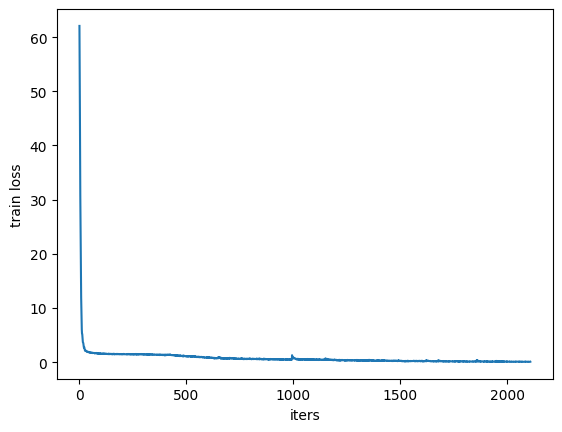

In [11]:
loss_graph(train_loss, 'train loss')

In [12]:
generate(model, x_test[:10], t_test[:10, 1:], 14, 10)

Q: 10/15/94                     
T: 1994-10-15
O: 1994-10-15
--
Q: thursday, november 13, 2008  
T: 2008-11-13
O: 2008-11-13
--
Q: Mar 25, 2003                 
T: 2003-03-25
O: 2003-03-25
--
Q: Tuesday, November 22, 2016   
T: 2016-11-22
O: 2016-11-22
--
Q: Saturday, July 18, 1970      
T: 1970-07-18
O: 1970-07-18
--
Q: october 6, 1992              
T: 1992-10-06
O: 1992-10-06
--
Q: 8/23/08                      
T: 2008-08-23
O: 2008-08-23
--
Q: 8/30/07                      
T: 2007-08-30
O: 2007-08-30
--
Q: 10/28/13                     
T: 2013-10-28
X: 193-10-28-
--
Q: sunday, november 6, 2016     
T: 2016-11-06
O: 2016-11-06
--
